# Bike Analysis and Demand Prediction for Washington DC

![Capitol Hill, Washington DC, USA](images/washington-dc.jpeg)

In [159]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import ml packages for preprocessing, model generation and metrics
from sklearn.linear_model import LinearRegression, RidgeCV, PoissonRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.stattools import adfuller

# options to display columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [160]:
# setting seaborn themes
sns.set_theme()
sns.set_palette('colorblind')

## Exploratory Data Analysis

We’ll start off by importing and loading the data into a data frame.

In [161]:
# import data
dc_bikes = pd.read_csv('data/finaldata.csv', parse_dates=["date"])

The data is already clean and preprocessed, we have not missing values nor duplicates. Still, we’d like to add weather labels in order to visualize them later.

In [162]:
# for exploratory data analysis, label days as windy, snow, rainy, sunny;
def labeling(awnd, prcp, snow, snwd):
    if prcp > 0.0:
        label = 'rain'
    elif snow > 0.0 or snwd > 0.0:
        label = 'snow'
    elif awnd >= 6.0: # windy days defined as above 6m/sec wind speed
        label = 'wind'
    else:
        label = 'sun'
    return label  
dc_bikes['weather'] = dc_bikes.apply(lambda x: labeling(x.awnd, x.prcp, x.snow, x.snwd), axis=1)

### Visualizations

Next, we’ll have a look at the distribution of the data.


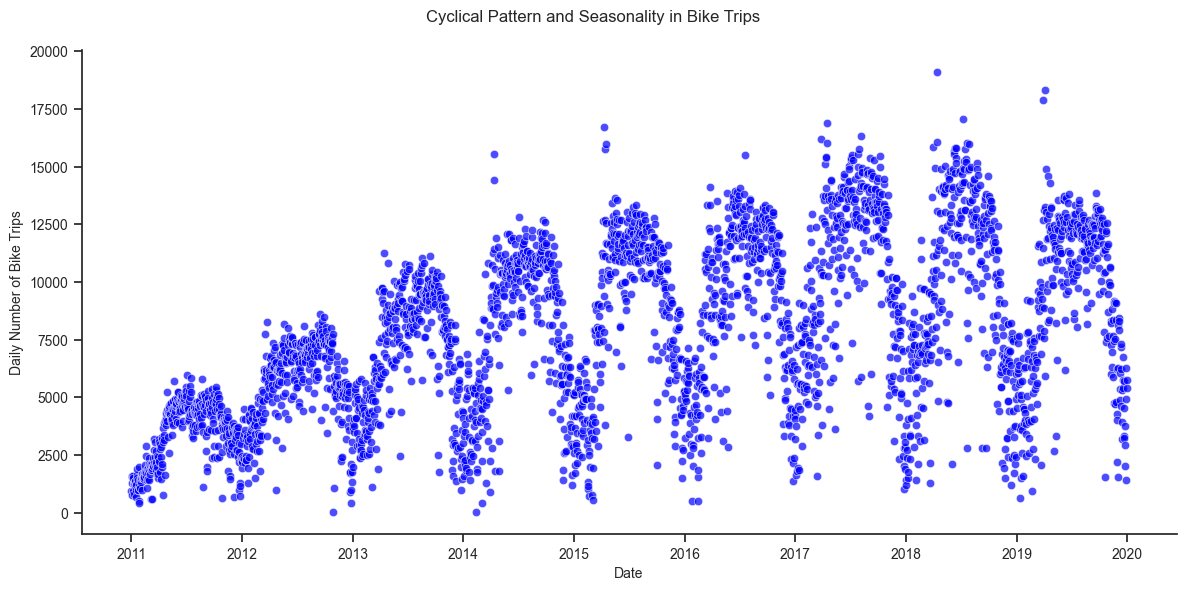

In [163]:
# plot daily bike usage (2011-2019)
sns.set(style='ticks')
sns.relplot(
    data=dc_bikes,
    x='date',
    y='numbikes',
    height=6,
    aspect=2,
    color='blue',
    alpha=.7)

plt.xlabel('Date', fontsize=10)
plt.ylabel('Daily Number of Bike Trips', fontsize=10)
plt.suptitle('Cyclical Pattern and Seasonality in Bike Trips', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(pad=1)
plt.show()

#plt.savefig('images/cyclical-daily-bikes.png')

We can clearly make out the cyclical and seasonal nature of the data. Bike trips are taken a lot more during summertime and rentals die down in the fall and winter months. Also of note are regular peaks which seem to happen each year in April. Let’s have a look into what’s going on here.

In [164]:
dc_bikes.loc[list(dc_bikes.groupby('year').numbikes.idxmax()),['date','numbikes','tmax','weather']]

,date,numbikes,tmax,weather
184,2011-07-04,5975,32.8,sun
623,2012-09-15,8623,25.6,sun
833,2013-04-13,11267,21.1,sun
1197,2014-04-12,15564,25.0,sun
1561,2015-04-11,16746,20.0,sun
2020,2016-07-17,15526,33.9,sun
2292,2017-04-15,16896,25.0,sun
2656,2018-04-14,19113,29.4,sun
3017,2019-04-06,18346,21.7,sun


Except for September 2012 and July 2016, the peaks in demand fall in early to mid-April, which is when Washington’s Cherry Blossom Festival takes place.

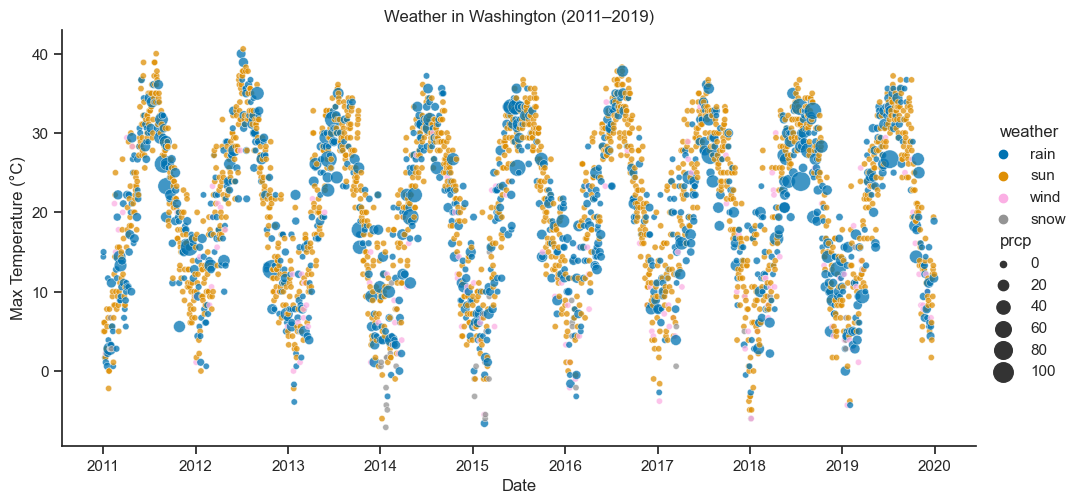

In [184]:
# plot max temperature over sample, indicating weather type and precipitation levels
palette = {'sun':"#de8f05", 'wind':"#fbafe4", 'rain':'#0173b2', 'snow':"#949494"}

sns.set(style='ticks')
sns.relplot(
    data=dc_bikes,
    x="date", 
    y="tmax", 
    size="prcp", # set size of data points to amount of precipitation
    sizes=(20,200),
    hue='weather', 
    palette=palette,
    aspect=2,
    alpha=.75
)

plt.xlabel("Date")
plt.ylabel("Max Temperature (°C)")
plt.title("Weather in Washington (2011–2019)")
plt.show()

#plt.savefig('images/cyclical-weather.png')

We can see that the temperature cycles remain stable over the years. Furthermore, rainy days seem to occur all year round in Washington DC. Finally, we can see that 2018 was a particularly rainy year, and this could be a reason as to why demand for bike rentals were down in 2018.

In [166]:
# bike trips by year, month, week, day of the week 
avg_bikes_year = dc_bikes.groupby('year')['numbikes'].mean().reset_index()
avg_bikes_month = dc_bikes.groupby('month')['numbikes'].mean().reset_index()
avg_bikes_week = dc_bikes.groupby('week')['numbikes'].mean().reset_index()
avg_bikes_day = dc_bikes.groupby('dayofweek')['numbikes'].mean().reset_index()
avg_bikes_day = avg_bikes_day.rename({'dayofweek': 'day'}, axis=1)

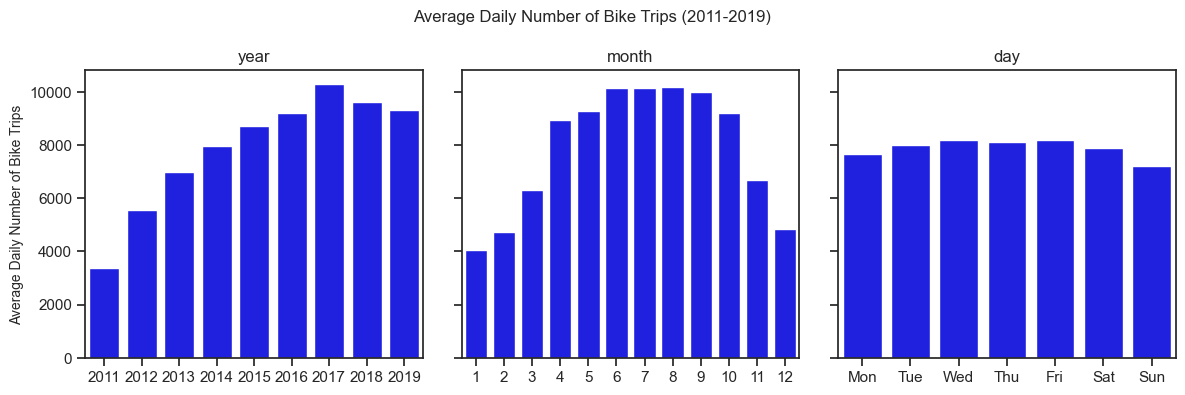

In [167]:
# average daily number of bike trips (2011-2019)
sns.set(style='ticks')
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
fig.suptitle('Average Daily Number of Bike Trips (2011-2019)', fontsize=12)
avg_bikes_df = [avg_bikes_year, avg_bikes_month, avg_bikes_day]
count = 0
for item in avg_bikes_df:
    sns.barplot(data=item, 
                x=item.iloc[:,0],
                y='numbikes',
                ax=ax[count],
                color='blue').set(title=f'{item.columns[0]}', xlabel='')
    count += 1
fig.tight_layout(pad=1)

# some axis customization on graph
ax[0].set_ylabel('Average Daily Number of Bike Trips', fontsize=10)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

#plt.savefig('images/avg-num-trips.png')

The graphs above show that there is a cyclical pattern in bike rentals over the year, with the daily number of bike trips peaking during the summer months. Furthermore, there is a drop in the daily number of bike trips in 2018 and 2019, which coincides with the introduction of e-scooter rentals. Additionally, 2018 was a particularly rainy year in Washington DC and this could partially explain the lower bike rental demand for this year (see above). Finally, average daily number of bike rentals is lower on Sundays and peaks in the middle of the week.

Text(0.5, 1.0, 'Correlation Matrix for Weather Features')

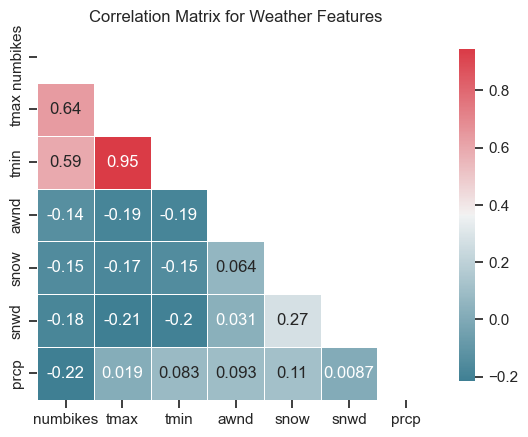

In [185]:
# checking for relationships among the features and between the features and the target
sns.set(style='ticks')
corr_mtrx = dc_bikes[['numbikes','tmax','tmin','awnd','snow','snwd','prcp']].corr()

mask = np.triu(corr_mtrx)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_mtrx, annot=True, mask=mask, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .9});
plt.title('Correlation Matrix for Weather Features')

#plt.savefig('images/corr-weather-features.png')

In [169]:
# check average number of daily bikes for each year
dc_bikes.groupby('year').numbikes.mean()

year
2011     3361.005479
2012     5543.472678
2013     7001.482192
2014     7981.232877
2015     8728.509589
2016     9209.928177
2017    10295.279452
2018     9600.769648
2019     9310.731507
Name: numbikes, dtype: float64

## Creating Models

Before we can start creating and running the models, we‘ll specify our features, i.e. calendar events and weather features. 

In [170]:
# define list of features for regression analysis
calendar_features = [f'dow_{i+1}' for i in range(0,6)] + \
                    [f'month_{i+1}' for i in range(1,12)] + \
                    [f'year_{i+1}' for i in range(2011,2018)] + \
                    ['sin_doy', 'cos_doy', 'sin_dow', 'cos_dow', 'holiday']
weather_features = ['awnd_log', 'prcp_log', 'snow_log',	'snwd_log', 'tmax', 'tmin']
all_features = [*calendar_features, *weather_features]

To make our lives a bit easier and not lose overview, let’s put all the steps required for a model to run into a function.

In [171]:
# we‘ll store the results in a dictionary, in order to compare those of different models
test_results = {}

# define function to train/test model and produce error analysis
def reg_predict(
    df = dc_bikes,
    features = calendar_features, # calendar_features, weather_features, or all_features
    train_year_end = 2018, # training year from 2011 up until year specified here
    test_year = 2019, # test year must be after train_year_end, must be between 2011 and 2019
    model = 'Linear', # choice of 'Linear', 'Polynomial', 'Ridge', 'Poisson', 'Random Forest', 'XGBoost'
    scaling = True, # default scaling (standardization) of x variables
    degree = 2, # quadratic polynomial is default for polynomial and ridge regression
    alphas = [0.01,0.1,1,10,100], # regularization grid for ridge regression
    n_estimators = 550, # number of estimators for xgboost regression
    max_features = 'sqrt' # maximum number of features for random forest
):
    ### regression analysis ###

    # define train/test years
    df_train = df[df['year'] <= train_year_end]
    df_test = df[df['year'] == test_year]

    # define X, y for train/test sample
    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train['log_numbikes']
    y_test = df_test['log_numbikes']

    # scaling standardization for features
    if scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # choice for regression models
    if model == 'Linear':
        regr = LinearRegression()
    elif model == 'Polynomial':
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression()
            )
    elif model == 'Ridge':
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            RidgeCV(alphas=alphas)
            )
    elif model == 'Poisson':
        regr = PoissonRegressor()
    elif model == 'XGBoost':
        regr = XGBRegressor(n_estimators=n_estimators, random_state=42)
    elif model == 'Random Forest':
        regr = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=42)
    else:
        assert False, f'Unknown model {model}'
    
    # fitting and prediction
    regr.fit(X_train, y_train)
    y_pred_train = regr.predict(X_train)
    y_pred = regr.predict(X_test)

    # print mape for train/test of model
    print('----------------------------------')
    print(f'{model} regression')
    print(f'Training Period: 2011-{train_year_end}')
    print(f'Test Period: {test_year}')
    print('----------------------------------')
    print(f'Train MAPE: {mean_absolute_percentage_error(y_train, y_pred_train).round(3)}')
    print(f'Test MAPE: {mean_absolute_percentage_error(y_test, y_pred).round(3)}')
    print('----------------------------------')

    # add test results to a dict for later comparison
    feature_string = 'Calendar' if features==calendar_features else 'Calendar + Weather'
    mod = model if model in ['Random Forest', 'XGBoost'] else model + ' Regression'
    test_results[mod] = [feature_string,  
                         mean_absolute_percentage_error(y_train, y_pred_train).round(3), 
                         mean_absolute_percentage_error(y_test, y_pred).round(3)
                        ]

    ### residuals analysis ###

    # define residuals
    residuals_test = y_test - y_pred

    # augmented dickey-fuller test for stationarity of residuals #
    print('ADF Test for Residual Stationarity')
    result = adfuller(residuals_test)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
	    print('\t%s: %.3f' % (key, value))
    print('----------------------------------')

    #  define subplots
    # sns.set(style='ticks')
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle(f'Residual Analysis: Test Period {test_year}, {model} regression', fontsize=12)

    # plot distribution of residuals
    plot_0 = sns.histplot(residuals_test, ax=ax[0], color='Blue')
    plot_0.grid(False)
    ax[0].set_xlabel('Residuals', fontsize=10)
    ax[0].set_ylabel('')
    
    # plot residuals vs predicted
    plot_1 = sns.scatterplot(x=y_pred, y=residuals_test, ax=ax[1], color='Blue')
    plot_1.grid(False)
    ax[1].set_xlabel('Predicted', fontsize=10)
    ax[1].set_ylabel('Residual', fontsize=10)
    plt.show()

----------------------------------
Linear regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.029
Test MAPE: 0.115
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -14.512662
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
----------------------------------


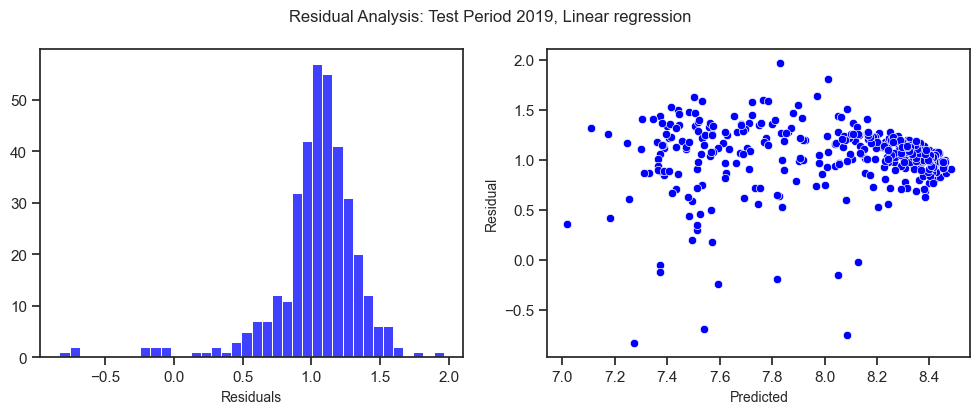

In [172]:
# baseline model 
reg_predict(features=calendar_features, model='Linear')

----------------------------------
Polynomial regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.026
Test MAPE: 0.115
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -4.116196
p-value: 0.000911
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


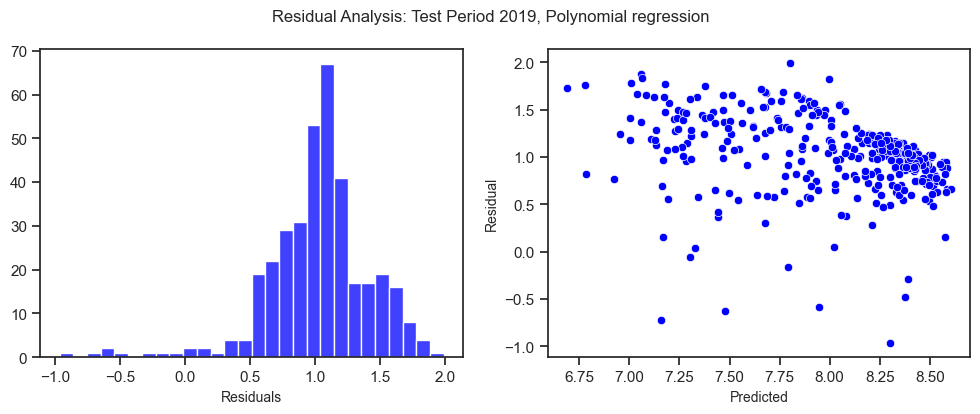

In [173]:
# polynomial regression degree=2
reg_predict(features=calendar_features, model='Polynomial')

----------------------------------
Ridge regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.025
Test MAPE: 0.116
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -3.487229
p-value: 0.008321
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


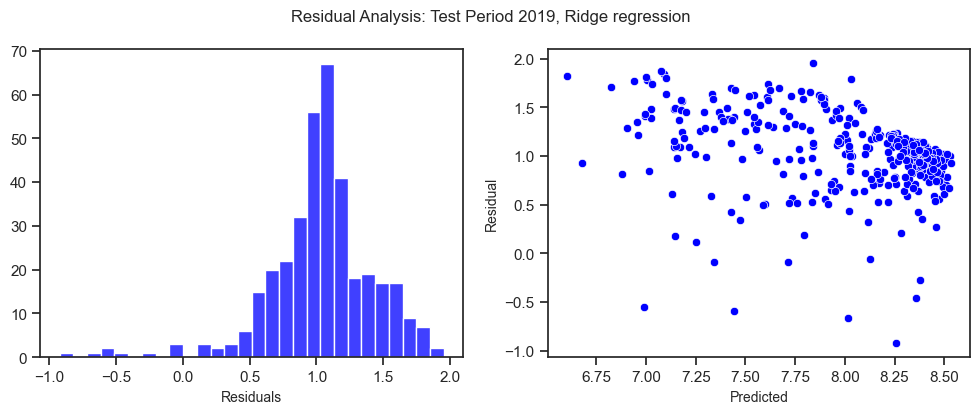

In [174]:
# ridge regression
reg_predict(features=calendar_features, model='Ridge')

----------------------------------
Poisson regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.033
Test MAPE: 0.08
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -3.923940
p-value: 0.001866
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


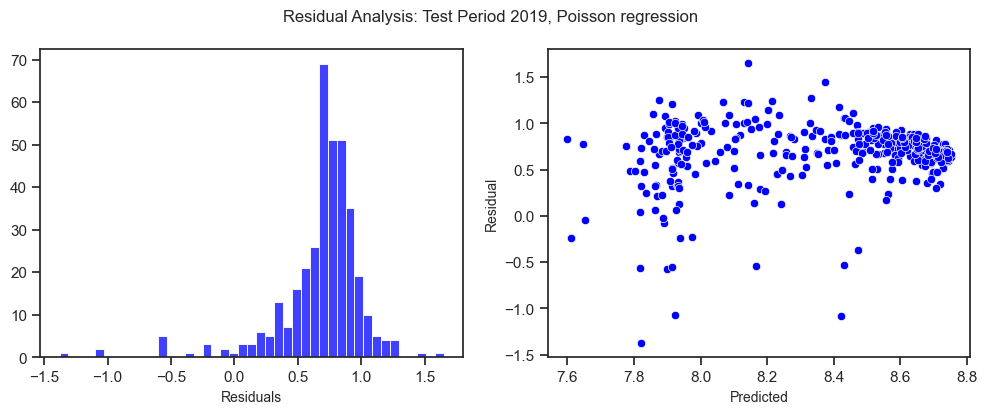

In [175]:
# poisson regression
reg_predict(features=calendar_features, model='Poisson')

----------------------------------
Linear regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.021
Test MAPE: 0.114
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -9.559114
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
----------------------------------


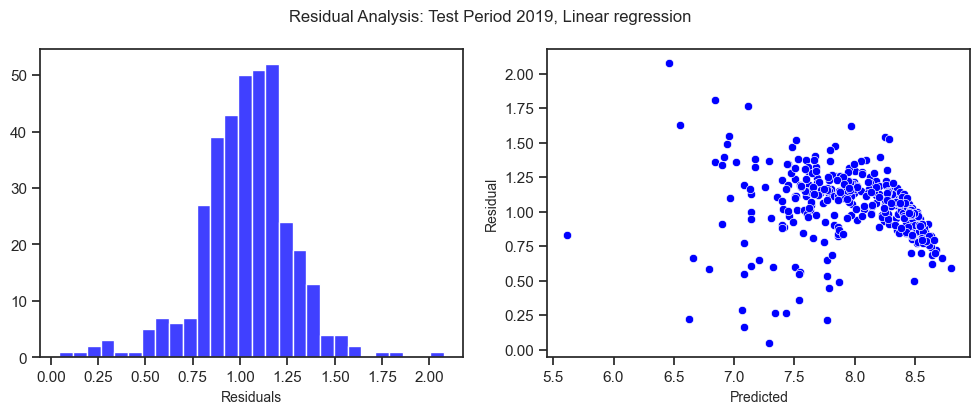

In [176]:
# linear regression with weather and calendar features
reg_predict(features=all_features, model='Linear')

----------------------------------
Polynomial regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.012
Test MAPE: 0.115
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -2.261849
p-value: 0.184568
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


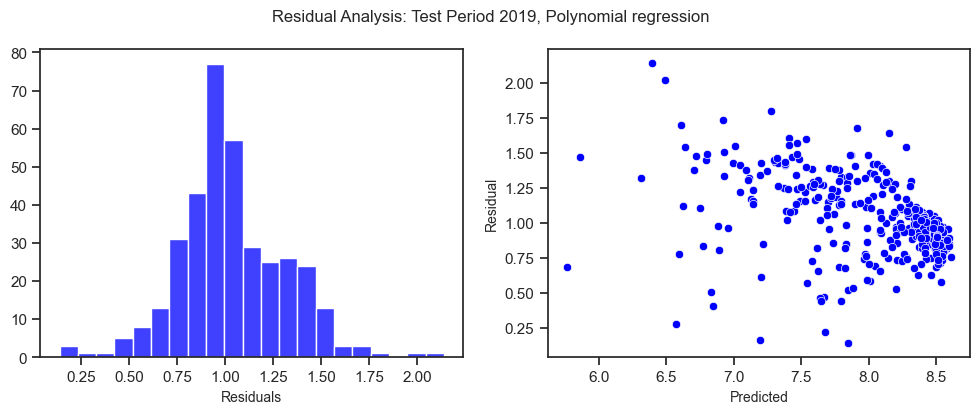

In [177]:
# polynomial regression degree=2 with weather and calendar features
reg_predict(features=all_features, model='Polynomial')

----------------------------------
Ridge regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.012
Test MAPE: 0.111
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -1.901257
p-value: 0.331470
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


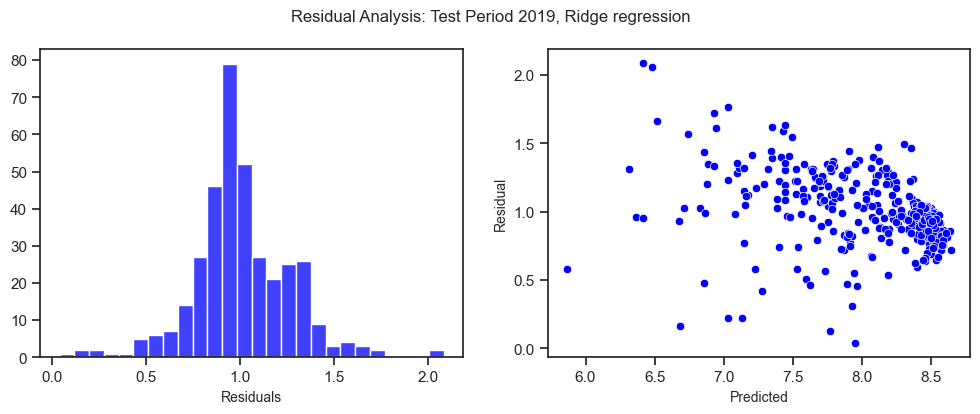

In [178]:
# ridge regression with weather and calendar features
reg_predict(features=all_features, model='Ridge')

----------------------------------
Poisson regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.025
Test MAPE: 0.076
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -8.460738
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


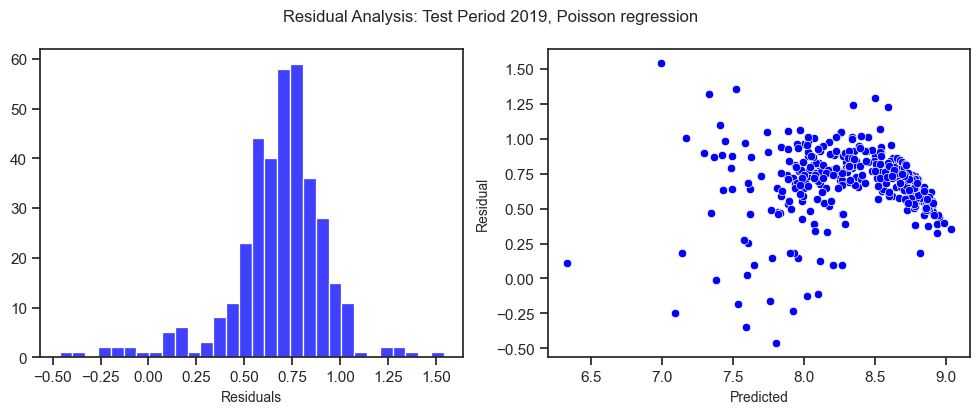

In [179]:
# poisson regression with weather and calendar features
reg_predict(features=all_features, model='Poisson')

----------------------------------
Random Forest regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.01
Test MAPE: 0.056
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -2.786490
p-value: 0.060230
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


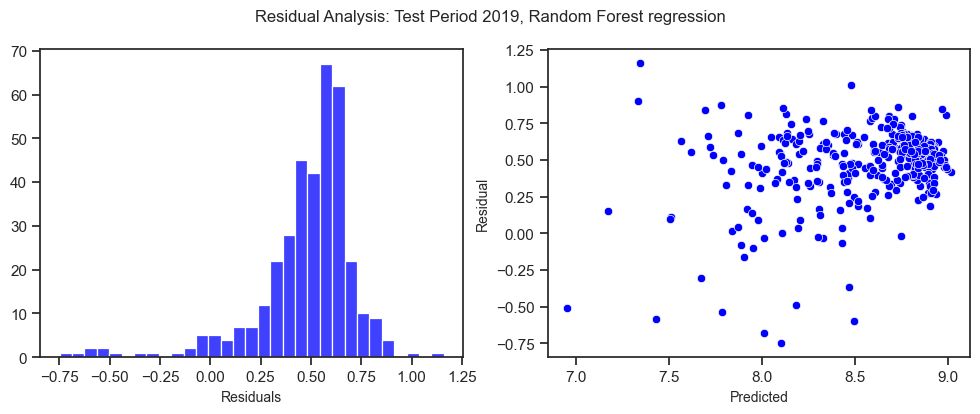

In [180]:
# random forest with weather and calendar features
reg_predict(features=all_features, model='Random Forest')

----------------------------------
XGBoost regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.0
Test MAPE: 0.105
----------------------------------
ADF Test for Residual Stationarity
ADF Statistic: -1.986800
p-value: 0.292390
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


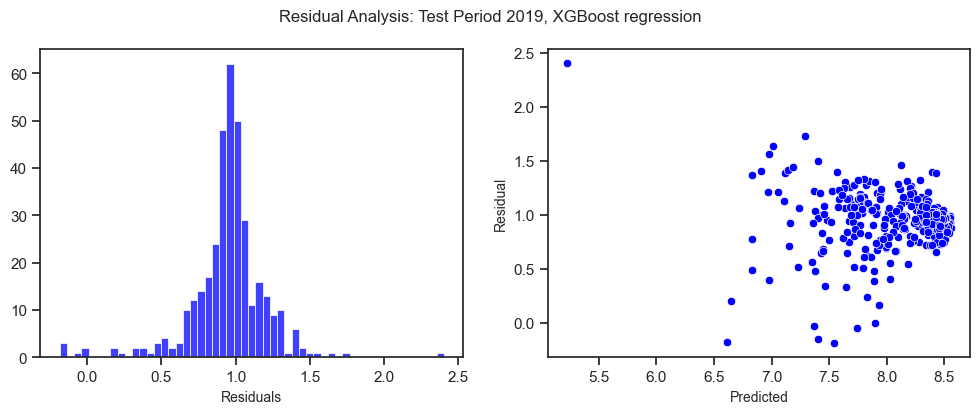

In [181]:
# xgboost with weather and calendar features
reg_predict(features=all_features, model='XGBoost')

In [182]:
# create a table of model results
pd.DataFrame(test_results, index=['Features', 'Train MAPE', 'Test MAPE']).T

,Features,Train MAPE,Test MAPE
Linear Regression,Calendar + Weather,0.021,0.114
Polynomial Regression,Calendar + Weather,0.012,0.115
Ridge Regression,Calendar + Weather,0.012,0.111
Poisson Regression,Calendar + Weather,0.025,0.076
Random Forest,Calendar + Weather,0.01,0.056
XGBoost,Calendar + Weather,0.0,0.105


In [183]:
test_results

{'Linear Regression': ['Calendar + Weather', 0.021, 0.114],
 'Polynomial Regression': ['Calendar + Weather', 0.012, 0.115],
 'Ridge Regression': ['Calendar + Weather', 0.012, 0.111],
 'Poisson Regression': ['Calendar + Weather', 0.025, 0.076],
 'Random Forest': ['Calendar + Weather', 0.01, 0.056],
 'XGBoost': ['Calendar + Weather', 0.0, 0.105]}